# Summary statistics of coastal change for African countries

* **Products used:** [DE Africa Coastlines]()



## Description

The rate of change points augmented with country (level 0) and province (level 1) labels will be used to generate continental scale statistics.

In [16]:
import geopandas as gpd
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from scipy.stats import linregress

## Load augmented rate of change

Only `good` rate of change measurements have been kept.
Admin boundary labels have been matched in preprocessing.


In [2]:
# coastlines version, v0.4.0(-2022) or v0.4.2 (-2023)
version = 'v0.4.2'

In [3]:
%%time
coastlines = gpd.read_file(f"../data/deafricacoastlines_{version}_geomorph_gadm.gpkg")

CPU times: user 11min 59s, sys: 3min 15s, total: 15min 15s
Wall time: 16min 38s


In [4]:
coastlines.head()

,index,uid,rate_time,sig_time,se_time,outl_time,dist_2000,dist_2001,dist_2002,dist_2003,...,Obs,Preds,Probs,geomorph_dist,GID_0,NAME_0,GID_1,NAME_1,GID_1_dist,geometry
0,0,sv0eefepeh,-0.03,0.611,0.05,None,3.64,2.26,0.57,0.86,...,None,None,NaN,NaN,EGY,Egypt,EGY.22_1,Janub Sina',0.0,POINT (3340565.133 3519971.822)
1,1,sv0eefg1n9,0.00,0.964,0.05,None,3.06,1.73,0.99,0.66,...,None,None,NaN,NaN,EGY,Egypt,EGY.22_1,Janub Sina',0.0,POINT (3340578.894 3519998.721)
2,2,sv0eefg66h,0.04,0.304,0.04,None,2.16,1.12,0.01,-0.37,...,None,None,NaN,NaN,EGY,Egypt,EGY.22_1,Janub Sina',0.0,POINT (3340594.004 3520024.805)
3,3,sv0eefg7v8,-0.05,0.357,0.05,None,5.65,2.87,2.28,1.40,...,None,None,NaN,NaN,EGY,Egypt,EGY.22_1,Janub Sina',0.0,POINT (3340608.287 3520051.329)
4,4,sv0eefgt19,-0.02,0.621,0.04,None,3.50,1.55,1.85,0.99,...,None,None,NaN,NaN,EGY,Egypt,EGY.22_1,Janub Sina',0.0,POINT (3340625.134 3520076.178)


In [17]:
%%time
def outlier_mad(points, thresh=3.5):
    """
    Use robust Median Absolute Deviation (MAD) outlier detection
    algorithm to detect outliers. Returns a boolean array with True if
    points are outliers and False otherwise.

    Parameters:
    -----------
    points :
        An n-observations by n-dimensions array of observations
    thresh :
        The modified z-score to use as a threshold. Observations with a
        modified z-score (based on the median absolute deviation) greater
        than this value will be classified as outliers.

    Returns:
    --------
    mask :
        A n-observations-length boolean array.

    References:
    ----------
    Source: https://github.com/joferkington/oost_paper_code/blob/master/utilities.py

    Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
    Handle Outliers", The ASQC Basic References in Quality Control:
    Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.
    """
    if len(points.shape) == 1:
        points = points[:, None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median) ** 2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh
    
def change_regress(
    y_vals,
    x_vals,
    x_labels,
    threshold=3.5,
    detrend_params=None,
    slope_var="slope",
    interc_var="intercept",
    pvalue_var="pvalue",
    stderr_var="stderr",
    outliers_var="outliers",
):
    """
    For a given row in a `pandas.DataFrame`, apply linear regression to
    data values (as y-values) and a corresponding sequence of x-values,
    and return 'slope', 'intercept', 'pvalue', and 'stderr' regression
    parameters.

    Before computing the regression, outliers are identified using a
    robust Median Absolute Deviation (MAD) outlier detection algorithm,
    and excluded from the regression. A list of these outliers will be
    recorded in the output 'outliers' variable.

    Parameters:
    -----------
    x_vals, y_vals : list of numeric values, or nd.array
        A sequence of values to use as the x and y variables
    x_labels : list
        A sequence of strings corresponding to each value in `x_vals`.
        This is used to label any observations that are flagged as
        outliers (often, this can simply be set to the same list
        provided to `x_vals`).
    threshold : float, optional
        The modified z-score to use as a threshold for detecting
        outliers using the MAD algorithm. Observations with a modified
        z-score (based on the median absolute deviation) greater
        than this value will be classified as outliers.
    detrend_params : optional
        Not currently used
    slope, interc_var, pvalue_var, stderr_var : strings, optional
        Strings giving the names to use for each of the output
        regression variables.
    outliers_var : string, optional
        String giving the name to use for the output outlier variable.

    Returns:
    --------
    mask :
        A `pandas.Series` containing regression parameters and lists
        of outliers.

    """

    # Drop invalid NaN rows
    xy_df = np.vstack([x_vals, y_vals]).T
    valid_bool = ~np.isnan(xy_df).any(axis=1)
    xy_df = xy_df[valid_bool]
    valid_labels = x_labels[valid_bool]

    # If detrending parameters are provided, apply these to the data to
    # remove the trend prior to running the regression
    if detrend_params:
        xy_df[:, 1] = xy_df[:, 1] - (
            detrend_params[0] * xy_df[:, 0] + detrend_params[1]
        )

    # Remove outliers using MAD
    outlier_bool = outlier_mad(xy_df, thresh=threshold)
    # outlier_bool = outlier_ransac(xy_df)
    xy_df = xy_df[~outlier_bool]
    valid_labels = valid_labels[~outlier_bool]

    # Create string of all outliers and invalid NaN rows
    outlier_set = set(x_labels) - set(valid_labels)
    outlier_str = " ".join(map(str, sorted(outlier_set)))

    # Compute linear regression
    lin_reg = linregress(x=xy_df[:, 0], y=xy_df[:, 1])

    # Return slope, p-values and list of outlier years excluded from regression
    results_dict = {
        slope_var: np.round(lin_reg.slope, 3),
        interc_var: np.round(lin_reg.intercept, 3),
        pvalue_var: np.round(lin_reg.pvalue, 3),
        stderr_var: np.round(lin_reg.stderr, 3),
        outliers_var: outlier_str,
    }

    return pd.Series(results_dict)
    
def calculate_regressions(points_gdf, x_years):
    """
    For each rate of change point along the baseline annual coastline,
    compute linear regression rates of change against both time and
    climate indices.

    Regressions are computed after removing outliers to ensure robust
    results.

    Parameters:
    -----------
    points_gdf : geopandas.GeoDataFrame
        A `geopandas.GeoDataFrame` containing rates of change points
        with 'dist_*' annual movement/distance data.
    x_years : list of integer years

    Returns:
    --------
    points_gdf : geopandas.GeoDataFrame
        A `geopandas.GeoDataFrame` containing rates of change points
        with additional attribute columns:

            'rate_*':  Slope of the regression
            'sig_*':   Significance of the regression
            'se_*':    Standard error of the  regression
            'outl_*':  A list of any outlier years excluded from the
                       regression
    """

    # Restrict climate and points data to years in datasets
    dist_years = [f"dist_{i}" for i in x_years]
    points_subset = points_gdf[dist_years]

    # Compute coastal change rates by linearly regressing annual
    # movements vs. time
    rate_out = points_subset.apply(
        lambda row: change_regress(
            y_vals=row.values.astype(float), x_vals=x_years, x_labels=x_years
        ),
        axis=1,
    )
    points_gdf[
        ["rate_time", "incpt_time", "sig_time", "se_time", "outl_time"]
    ] = rate_out

    # Copy slope and intercept into points_subset so they can be
    # used to temporally de-trend annual distances
    points_subset[["slope", "intercept"]] = rate_out[["slope", "intercept"]]

    # Custom sorting
    reg_cols = ["rate_time", "sig_time", "se_time", "outl_time"]

    return points_gdf.loc[
        :, [*reg_cols, *dist_years, "angle_mean", "angle_std", "geometry"]
    ]


recent_years = np.arange(2016,2022)
# Calculate rates of change using linear regression
points_gdf = calculate_regressions(coastlines.copy(), recent_years)

<timed exec>:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CPU times: user 4min 57s, sys: 2min 43s, total: 7min 41s
Wall time: 8min 50s


In [18]:
points_gdf.head()

,rate_time,sig_time,se_time,outl_time,dist_2016,dist_2017,dist_2018,dist_2019,dist_2020,dist_2021,angle_mean,angle_std,geometry
0,-0.131,0.537,0.194,,1.62,1.04,-0.28,1.44,1.34,0.18,120,11,POINT (3340565.133 3519971.822)
1,-0.049,0.874,0.292,,1.92,2.13,-0.27,2.61,2.36,0.86,117,6,POINT (3340578.894 3519998.721)
2,0.281,0.213,0.190,,0.99,1.07,0.43,2.75,2.34,1.73,114,11,POINT (3340594.004 3520024.805)
3,0.052,0.886,0.341,,1.69,2.45,1.52,4.80,2.55,1.34,126,10,POINT (3340608.287 3520051.329)
4,-0.063,0.729,0.169,,1.25,1.93,1.02,2.37,1.78,0.63,115,11,POINT (3340625.134 3520076.178)


In [19]:
coastlines = coastlines.join(points_gdf[["rate_time", "sig_time", "se_time", "outl_time"]],
                rsuffix=f'_{recent_years[0]}_{recent_years[-1]}')

In [20]:
# Probability of recent rate larger than rate+se ~ (0.5-0.341)
# Probability of all time rate smaller than rate-se ~ 0.5-0.341

## Summarize change for each country

In [28]:
countries = coastlines.NAME_0.unique()
countries = [c for c in countries if str(c)!='nan' and (c!='Spain') and (c!=None)]

In [29]:
countries_summary = pd.DataFrame(countries, columns=["Country"])
countries_summary[['perc_neg05', 'perc_no', 'perc_pos05', 'km_neg05', 'km_no', 'km_pos05']] = [np.nan]*6
countries_summary[['perc_negsm10', 'perc_nosm', 'perc_possm10', 'km_negsm10', 'km_nosm', 'km_possm10']] = [np.nan]*6
countries_summary[['perc_negsm5_2000_2011', 'perc_possm5_2000_2011', 'perc_negsm5_2010_2021', 'perc_possm5_2010_2021']] = [np.nan]*4
countries_summary[['perc_neg05_acc', 'km_neg05_acc']] = [np.nan]*2

In [30]:
for idx in countries_summary.index:
    good_rates = coastlines[coastlines[f"NAME_0"]==countries_summary.loc[idx][f"Country"]]
    if len(good_rates)==0:
        print("no data over", countries_summary.loc[idx][f"Country"])
        continue

    # get stats
    total = len(good_rates)
    perc_neg05 = ((good_rates.sig_time<0.01) & (good_rates.rate_time<-0.5)).sum()*100/total
    perc_pos05 = ((good_rates.sig_time<0.01) & (good_rates.rate_time>0.5)).sum()*100/total
    perc_no = 100. - perc_neg05 - perc_pos05
    perc_negsm10 = (good_rates.nsm<-10).sum()*100/total
    perc_possm10 = (good_rates.nsm>10).sum()*100/total
    perc_nosm = 100. - perc_negsm10 - perc_possm10
    
    change_2000_2011 = good_rates.dist_2011-good_rates.dist_2000
    change_2010_2021 = good_rates.dist_2021-good_rates.dist_2010
    perc_negsm5_2000_2011 = ((good_rates.sig_time<0.01) & (change_2000_2011<-5)).sum()*100/total
    perc_possm5_2000_2011 = ((good_rates.sig_time<0.01) & (change_2000_2011>5)).sum()*100/total
    perc_negsm5_2010_2021 = ((good_rates.sig_time<0.01) &(change_2010_2021<-5)).sum()*100/total
    perc_possm5_2010_2021 = ((good_rates.sig_time<0.01) &(change_2010_2021>5)).sum()*100/total
  
    total_km = total*30/1000
    km_neg05 = ((good_rates.sig_time<0.01) & (good_rates.rate_time<-0.5)).sum()*30/1000
    km_pos05 = ((good_rates.sig_time<0.01) & (good_rates.rate_time>0.5)).sum()*30/1000
    km_no = total_km - km_neg05 - km_pos05
    km_negsm10 = (good_rates.nsm<-10).sum()*30/1000
    km_possm10 = (good_rates.nsm>10).sum()*30/1000
    km_nosm = total_km - km_negsm10 - km_possm10

    for cname in ['perc_neg05', 'perc_no', 'perc_pos05', 'km_neg05', 'km_no', 'km_pos05']:
        countries_summary.at[idx, cname] = eval(cname)
    
    for cname in ['perc_negsm10', 'perc_nosm', 'perc_possm10', 'km_negsm10', 'km_nosm', 'km_possm10']:
        countries_summary.at[idx, cname] = eval(cname)
    
    for cname in ['perc_negsm5_2000_2011', 'perc_possm5_2000_2011', 'perc_negsm5_2010_2021', 'perc_possm5_2010_2021']:
        countries_summary.at[idx, cname] = eval(cname)
    
    # 1.96* - retreating faster at higher than 99% confidence (only 0.025*0.025 probability to overlap)
    # 1* - retreating faster at higher than 97% confidence (only 0.16*0.16 probability to overlap)
    neg05_acc = (good_rates.sig_time<0.01) & (good_rates.rate_time<-0.5) & (
        (good_rates[f'rate_time_{recent_years[0]}_{recent_years[-1]}']+good_rates[f'se_time_{recent_years[0]}_{recent_years[-1]}'])
        < (good_rates.rate_time-good_rates.se_time)
    ) & (good_rates[f'sig_time_{recent_years[0]}_{recent_years[-1]}']<0.01)
    countries_summary.at[idx, "perc_neg05_acc"] = neg05_acc.sum()*100/len(good_rates)
    countries_summary.at[idx, "km_neg05_acc"] = neg05_acc.sum()*30/1000

In [31]:
countries_summary.head()

,Country,perc_neg05,perc_no,perc_pos05,km_neg05,km_no,km_pos05,perc_negsm10,perc_nosm,perc_possm10,km_negsm10,km_nosm,km_possm10,perc_negsm5_2000_2011,perc_possm5_2000_2011,perc_negsm5_2010_2021,perc_possm5_2010_2021,perc_neg05_acc,km_neg05_acc
0,Egypt,12.466732,77.477667,10.055601,425.79,2646.18,343.44,18.004866,69.339552,12.655582,614.94,2368.23,432.24,13.888816,9.338850,10.038912,13.755303,1.444922,49.35
1,Mozambique,19.404368,59.688455,20.907177,1017.60,3130.17,1096.41,24.881869,47.698592,27.419539,1304.85,2501.40,1437.93,18.691006,20.145762,21.441484,17.760260,3.208128,168.24
2,Western Sahara,9.616172,86.051777,4.332051,105.75,946.32,47.64,18.171154,74.875194,6.953651,199.83,823.41,76.47,12.076820,2.910767,8.527703,6.116158,1.988706,21.87
3,Sudan,9.467596,80.239651,10.292753,143.88,1219.41,156.42,19.659672,66.829856,13.510472,298.77,1015.62,205.32,10.326312,12.195748,8.788519,11.966757,0.444164,6.75
4,Mauritania,19.972107,53.848380,26.179512,227.70,613.92,298.47,26.732100,39.738968,33.528932,304.77,453.06,382.26,18.130148,24.724364,15.682972,26.503171,2.644528,30.15


## Plot as stacked bar charts

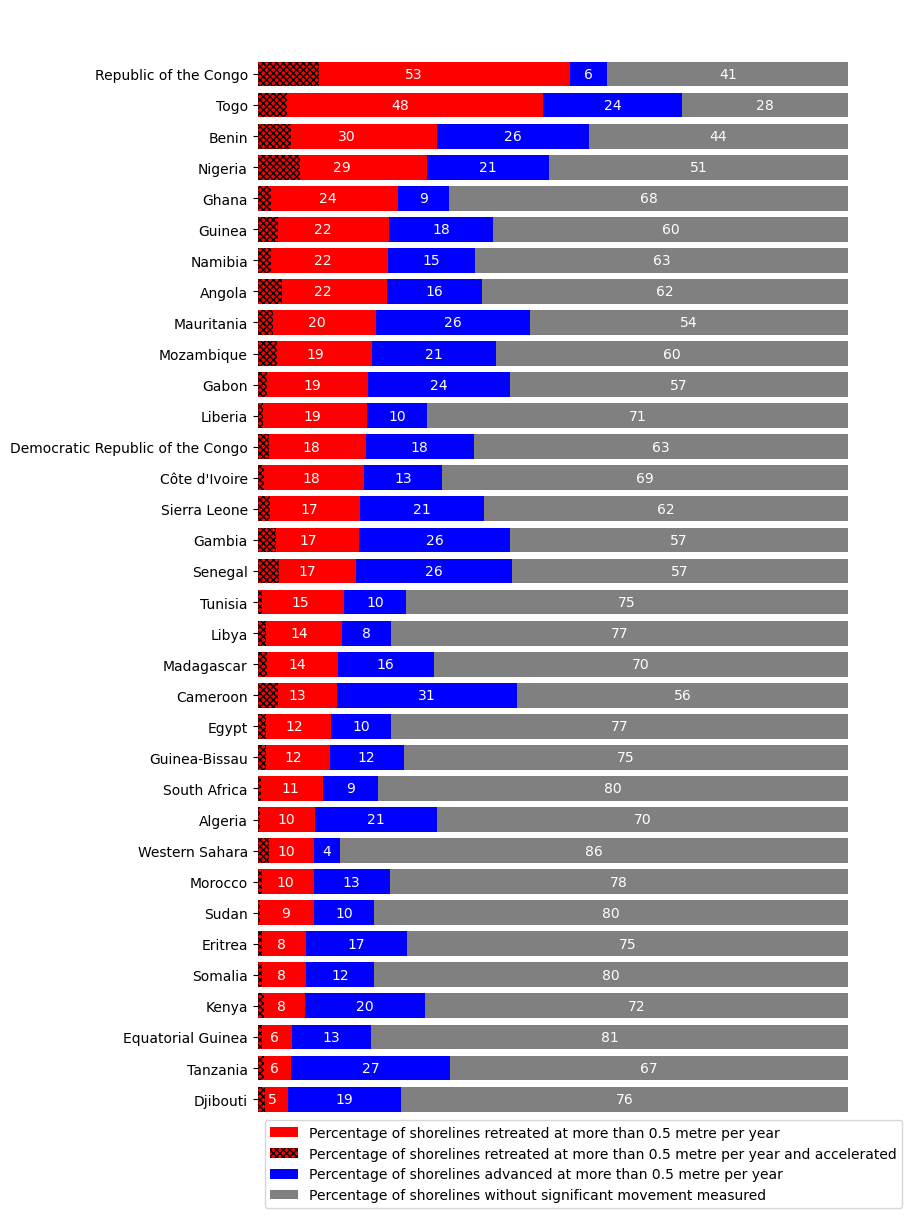

In [32]:
countries_sorted = countries_summary.sort_values(by='perc_neg05')

countries = list(countries_sorted.Country)
neg_data = list(countries_sorted.perc_neg05)
pos_data = list(countries_sorted.perc_pos05)
no_data = list(countries_sorted.perc_no)
acc_data = list(countries_sorted.perc_neg05_acc)
# Set the color scheme for the segments
colors = ['red', 'blue', 'grey']

# Create a list of indices for the bars
indices = np.arange(len(countries))

fig, ax = plt.subplots(figsize=(8,15))

# Plot the stacked horizontal bars
neg_bars = ax.barh(indices, neg_data, color=colors[0], label='Percentage of shorelines retreated at more than 0.5 metre per year')
acc_bars = ax.barh(indices, acc_data, color=colors[0], hatch = 'xxxxx', label='Percentage of shorelines retreated at more than 0.5 metre per year and accelerated')
pos_bars = ax.barh(indices, pos_data, left=neg_data, color=colors[1], label='Percentage of shorelines advanced at more than 0.5 metre per year')
no_bars = ax.barh(indices, no_data, left=np.add(neg_data, pos_data), color=colors[2], label='Percentage of shorelines without significant movement measured')

# Remove spines and ticks
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

# Add data value text to the center of each colored bar segment
for bars in [neg_bars, pos_bars, no_bars]:
    for bar in bars:
        width = bar.get_width()
        x_center = bar.get_x() + bar.get_width() / 2
        y_center = bar.get_y() + bar.get_height() / 2
        ax.text(x_center, y_center, str(round(width)), ha='center', va='center', color='white')

# Set the y-axis ticks and labels
ax.set_yticks(indices)
ax.set_yticklabels(countries)

# Place the legend outside of the figure
ax.legend(loc='center left', bbox_to_anchor=(0, 0), ncol=1)

fig.savefig('../figure/countries_rate_perc.png', bbox_inches='tight')

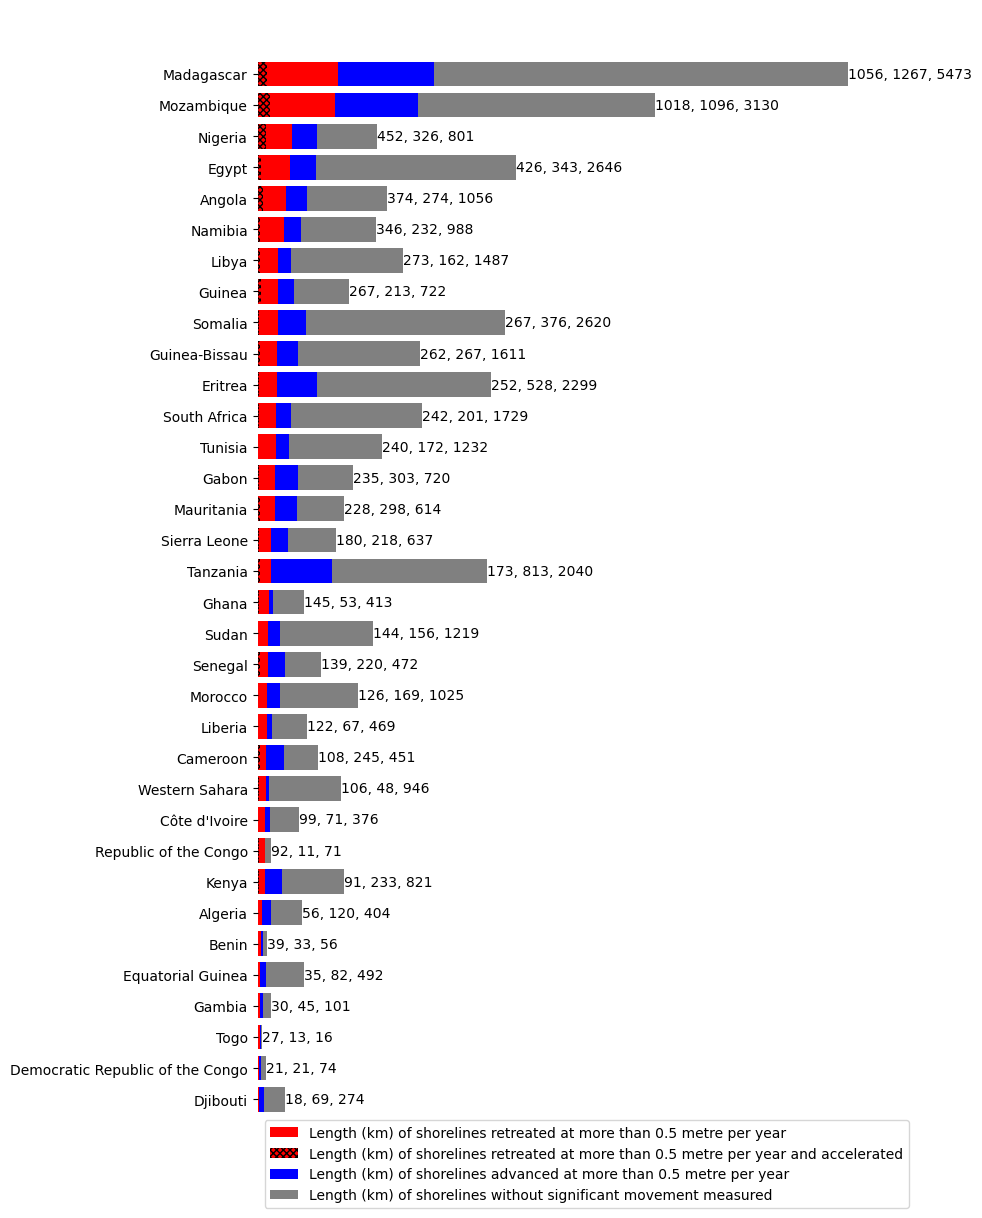

In [33]:
countries_sorted = countries_summary.sort_values(by='km_neg05')

countries = list(countries_sorted.Country)
neg_data = list(countries_sorted.km_neg05)
pos_data = list(countries_sorted.km_pos05)
no_data = list(countries_sorted.km_no)
acc_data = list(countries_sorted.km_neg05_acc)

# Set the color scheme for the segments
colors = ['red', 'blue', 'grey']

# Create a list of indices for the bars
indices = np.arange(len(countries))

fig, ax = plt.subplots(figsize=(8,15))

# Plot the stacked horizontal bars
neg_bars = ax.barh(indices, neg_data, color=colors[0], label='Length (km) of shorelines retreated at more than 0.5 metre per year')
acc_bars = ax.barh(indices, acc_data, color=colors[0], hatch = 'xxxxx', label='Length (km) of shorelines retreated at more than 0.5 metre per year and accelerated')
pos_bars = ax.barh(indices, pos_data, left=neg_data, color=colors[1], label='Length (km) of shorelines advanced at more than 0.5 metre per year')
no_bars = ax.barh(indices, no_data, left=np.add(neg_data, pos_data), color=colors[2], label='Length (km) of shorelines without significant movement measured')

# Remove spines and ticks
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

# Add data value text to the center of each bar segment
for i in range(len(countries)):
    total_width = neg_data[i] + pos_data[i] + no_data[i]
    x_center = total_width
    y_center = indices[i]
    ax.text(x_center, y_center, f"{round(neg_data[i])}, {round(pos_data[i])}, {round(no_data[i])}", ha='left', va='center')

# Set the y-axis ticks and labels
ax.set_yticks(indices)
ax.set_yticklabels(countries)

# Place the legend outside of the figure
ax.legend(loc='center left', bbox_to_anchor=(0, 0), ncol=1)

fig.savefig('../figure/countries_rate_km.png',bbox_inches='tight')

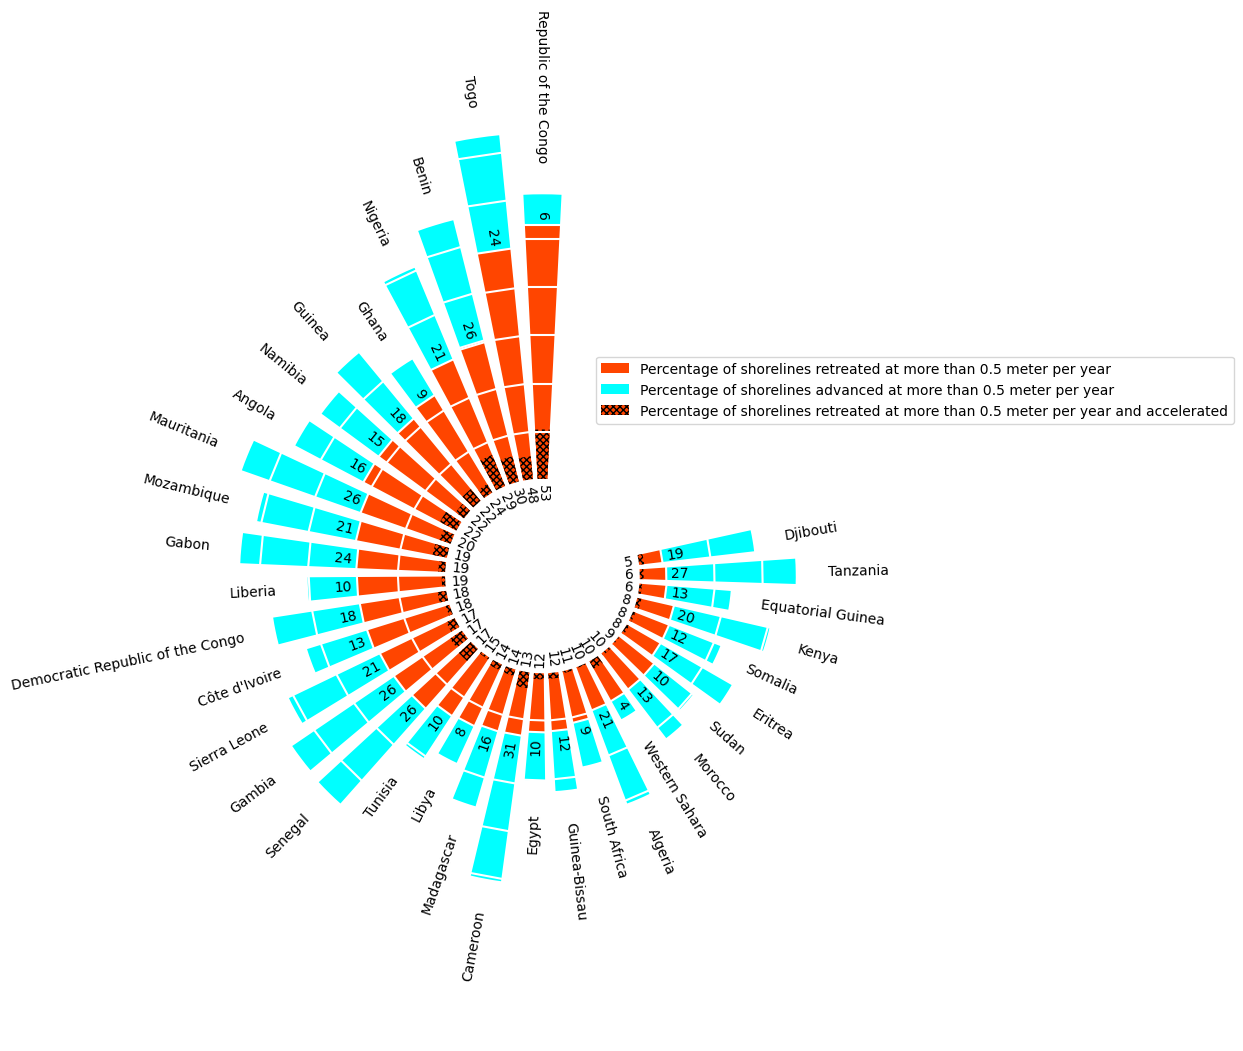

In [34]:
countries_sorted = countries_summary.sort_values(by='perc_neg05', ascending=False)


countries = list(countries_sorted.Country)
neg_data = list(countries_sorted.perc_neg05)
pos_data = list(countries_sorted.perc_pos05)
acc_data = list(countries_sorted.perc_neg05_acc)

# Set the color scheme for the segments
colors = ['orangered', 'cyan', 'grey']

# Calculate the angle for each bar
angles = np.linspace(0, 1.6*np.pi, len(countries), endpoint=False)

# Create a polar plot
fig = plt.figure(figsize=(12, 16))
ax = fig.add_subplot(111, polar=True)

base= 20 #[np.max(neg_data)/2]*len(neg_data)
w=0.1
# Plot the red segments
ax.bar(angles, base, width=w, color='white')
neg_bars = ax.bar(angles, neg_data, width=w, bottom=base, color=colors[0], label='Percentage of shorelines retreated at more than 0.5 meter per year')
# Plot the white segments on top of the red segments
pos_bars = ax.bar(angles, pos_data, width=w, bottom=np.add(base, neg_data), color=colors[1], label='Percentage of shorelines advanced at more than 0.5 meter per year')
# Plot the blue segments on top of the red and white segments
#ax.bar(angles, blue_data, width=0.5, bottom=np.add(red_data, white_data), color=colors[2], label='Blue')
acc_bars = ax.bar(angles, acc_data, width=w, bottom=base, color=colors[0], hatch='xxxxx', label='Percentage of shorelines retreated at more than 0.5 meter per year and accelerated')

# Set the starting angle at the top (North)
ax.set_theta_zero_location("N")

# Set the clockwise direction for the bars
ax.set_theta_direction(1)

# Set the tick labels
ax.set_xticks([])

ax.set_yticks([])
ax.axis("off")
# Set the radial grid lines every 10 percent
#ax.set_yticks(np.arange(0, 101, 10))
#ax.yaxis.grid(color='white', linewidth=2)

# Remove the radial tick labels
ax.set_yticklabels([])
# Remove the outer frame (circle)
ax.spines['polar'].set_visible(False)

# Place the legend outside of the figure
ax.legend(loc='center left', bbox_to_anchor=(0.55, 0.7), ncol=1)

# Add country labels radially
for angle, country, label_radius in zip(angles, countries, np.add(np.add(np.add(neg_data, pos_data), base), np.max(neg_data)/8)):
    if angle<np.pi: rot, ha = 270, 'right'
    else: rot, ha = 90, 'left'
    ax.text(angle, label_radius, country, ha=ha, va='center', fontsize=10,
            rotation=rot,#np.degrees(angle), 
            rotation_mode='anchor', transform_rotates_text=True)

# Add data value text to the center of each colored bar segment
for bars in [neg_bars]:
    for bar in bars:
        h = bar.get_height()
        x_center = bar.get_x() + bar.get_width() / 2
        y_center = bar.get_y() -1 #+ bar.get_height() / 2
        if x_center<np.pi: rot, ha = 270, 'left'
        else: rot, ha = 90, 'right'
        ax.text(x_center, y_center, str(round(h)), ha=ha, va='center', fontsize=10, 
                color='black', rotation=rot, rotation_mode='anchor', transform_rotates_text=True)
        for y in np.arange(bar.get_y(), bar.get_y()+bar.get_height(), 10):
            ax.plot([x_center-bar.get_width() / 2, x_center+bar.get_width() / 2], 
                    [y, y], color='white')
for bars in [pos_bars]:
    for bar in bars:
        h = bar.get_height()
        x_center = bar.get_x() + bar.get_width() / 2
        y_center = bar.get_y() + 1#+ bar.get_height() / 2
        if x_center<np.pi: rot, ha = 270, 'right'
        else: rot, ha = 90, 'left'
        ax.text(x_center, y_center, str(round(h)), ha=ha, va='center', fontsize=10, 
                color='black', rotation=rot, rotation_mode='anchor', transform_rotates_text=True)
        for y in np.arange(bar.get_y(), bar.get_y()+bar.get_height(), 10):
            ax.plot([x_center-bar.get_width() / 2, x_center+bar.get_width() / 2], 
                    [y, y], color='white')
        
        
fig.savefig('../figure/countries_rate_perc_polar_270_withnumbers.png',bbox_inches='tight')
#fig.savefig('../figure/countries_rate_perc_polar_270_nonumbers.png',bbox_inches='tight')

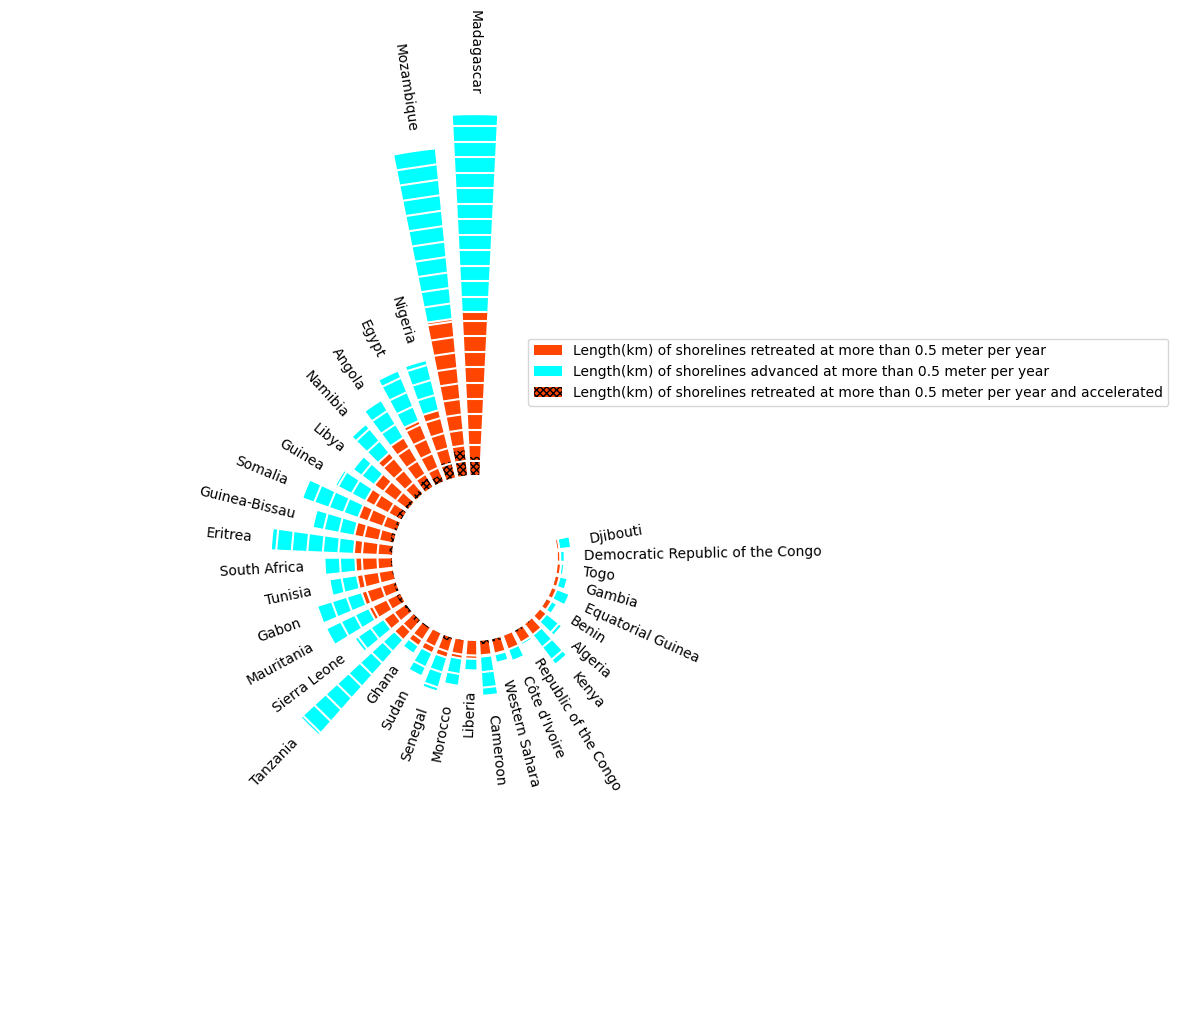

In [35]:
countries_sorted = countries_summary.sort_values(by='km_neg05', ascending=False)

countries = list(countries_sorted.Country)
neg_data = list(countries_sorted.km_neg05)
pos_data = list(countries_sorted.km_pos05)
acc_data = list(countries_sorted.km_neg05_acc)

# Set the color scheme for the segments
colors = ['orangered', 'cyan', 'grey']

# Calculate the angle for each bar
angles = np.linspace(0, 1.6*np.pi, len(countries), endpoint=False)

# Create a polar plot
fig = plt.figure(figsize=(12, 16))
ax = fig.add_subplot(111, polar=True)

base= [np.max(neg_data)/2]*len(neg_data)
w=0.1
# Plot the red segments
ax.bar(angles, base, width=w, color='white')
neg_bars = ax.bar(angles, neg_data, width=w, bottom=base, color=colors[0], label='Length(km) of shorelines retreated at more than 0.5 meter per year')
# Plot the white segments on top of the red segments
pos_bars = ax.bar(angles, pos_data, width=w, bottom=np.add(base, neg_data), color=colors[1], label='Length(km) of shorelines advanced at more than 0.5 meter per year')
# Plot the blue segments on top of the red and white segments
#ax.bar(angles, blue_data, width=0.5, bottom=np.add(red_data, white_data), color=colors[2], label='Blue')
acc_bars = ax.bar(angles, acc_data, width=w, bottom=base, color=colors[0], hatch='xxxxx', label='Length(km) of shorelines retreated at more than 0.5 meter per year and accelerated')

# Set the starting angle at the top (North)
ax.set_theta_zero_location("N")

# Set the clockwise direction for the bars
ax.set_theta_direction(1)

# Set the tick labels
ax.set_xticks([])

ax.set_yticks([])
ax.axis("off")
# Set the radial grid lines every 10 percent
#ax.set_yticks(np.arange(0, 101, 10))
#ax.yaxis.grid(color='white', linewidth=2)

# Remove the radial tick labels
ax.set_yticklabels([])
# Remove the outer frame (circle)
ax.spines['polar'].set_visible(False)

# Place the legend outside of the figure
ax.legend(loc='center left', bbox_to_anchor=(0.55, 0.7), ncol=1)

# Add country labels radially
for angle, country, label_radius in zip(angles, countries, np.add(np.add(np.add(neg_data, pos_data), base), np.max(neg_data)/8)):
    if angle<np.pi: rot, ha = 270, 'right'
    else: rot, ha = 90, 'left'
    ax.text(angle, label_radius, country, ha=ha, va='center', fontsize=10,
            rotation=rot,#np.degrees(angle), 
            rotation_mode='anchor', transform_rotates_text=True)

# Add data value text to the center of each colored bar segment
for bars in [neg_bars]:
    for bar in bars:
        h = bar.get_height()
        x_center = bar.get_x() + bar.get_width() / 2
        y_center = bar.get_y() -1 #+ bar.get_height() / 2
        if x_center<np.pi: rot, ha = 270, 'left'
        else: rot, ha = 90, 'right'
        #ax.text(x_center, y_center, str(round(h)), ha=ha, va='center', fontsize=10, 
        #        color='black', rotation=rot, rotation_mode='anchor', transform_rotates_text=True)
        for y in np.arange(bar.get_y(), bar.get_y()+bar.get_height(), 100):
            ax.plot([x_center-bar.get_width() / 2, x_center+bar.get_width() / 2], 
                    [y, y], color='white')
for bars in [pos_bars]:
    for bar in bars:
        h = bar.get_height()
        x_center = bar.get_x() + bar.get_width() / 2
        y_center = bar.get_y() + 1#+ bar.get_height() / 2
        if x_center<np.pi: rot, ha = 270, 'right'
        else: rot, ha = 90, 'left'
        #ax.text(x_center, y_center, str(round(h)), ha=ha, va='center', fontsize=10, 
        #        color='black', rotation=rot, rotation_mode='anchor', transform_rotates_text=True)
        for y in np.arange(bar.get_y(), bar.get_y()+bar.get_height(), 100):
            ax.plot([x_center-bar.get_width() / 2, x_center+bar.get_width() / 2], 
                    [y, y], color='white')
        
        
fig.savefig('../figure/countries_rate_km_polar_270_withnumbers.png',bbox_inches='tight')
#fig.savefig('../figure/countries_rate_km_polar_270_nonumbers.png',bbox_inches='tight')

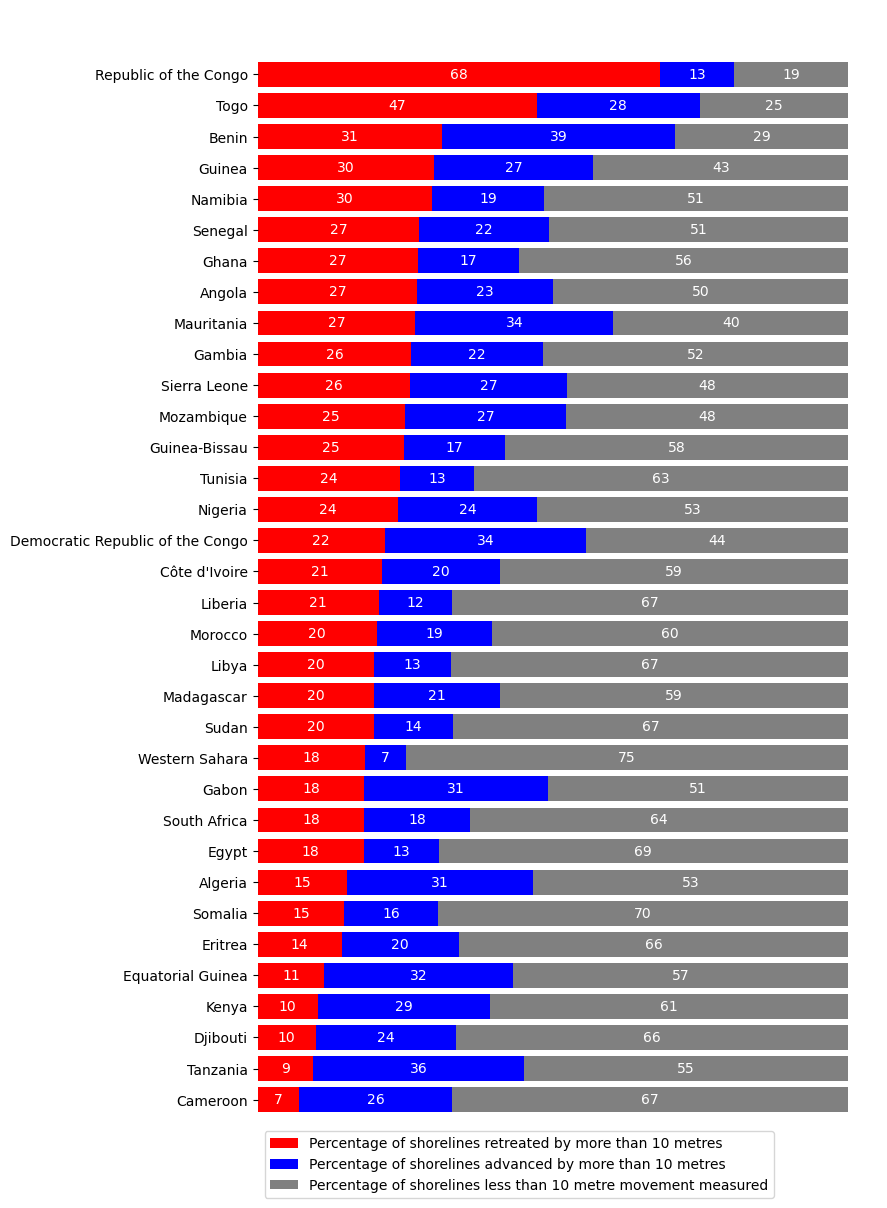

In [36]:
countries_sorted = countries_summary.sort_values(by='perc_negsm10')

countries = list(countries_sorted.Country)
red_data = list(countries_sorted.perc_negsm10)
white_data = list(countries_sorted.perc_possm10)
blue_data = list(countries_sorted.perc_nosm)

# Set the color scheme for the segments
colors = ['red', 'blue', 'grey']

# Create a list of indices for the bars
indices = np.arange(len(countries))

fig, ax = plt.subplots(figsize=(8,15))

# Plot the stacked horizontal bars
red_bars = ax.barh(indices, red_data, color=colors[0], label='Percentage of shorelines retreated by more than 10 metres')
white_bars = ax.barh(indices, white_data, left=red_data, color=colors[1], label='Percentage of shorelines advanced by more than 10 metres')
blue_bars = ax.barh(indices, blue_data, left=np.add(red_data, white_data), color=colors[2], label='Percentage of shorelines less than 10 metre movement measured')

# Remove spines and ticks
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

# Add data value text to the center of each colored bar segment
for bars in [red_bars, white_bars, blue_bars]:
    for bar in bars:
        width = bar.get_width()
        x_center = bar.get_x() + bar.get_width() / 2
        y_center = bar.get_y() + bar.get_height() / 2
        ax.text(x_center, y_center, str(round(width)), ha='center', va='center', color='white')

# Set the y-axis ticks and labels
ax.set_yticks(indices)
ax.set_yticklabels(countries)

# Place the legend outside of the figure
ax.legend(loc='center left', bbox_to_anchor=(0, 0), ncol=1)

fig.savefig('../figure/countries_sm_perc.png', bbox_inches='tight')

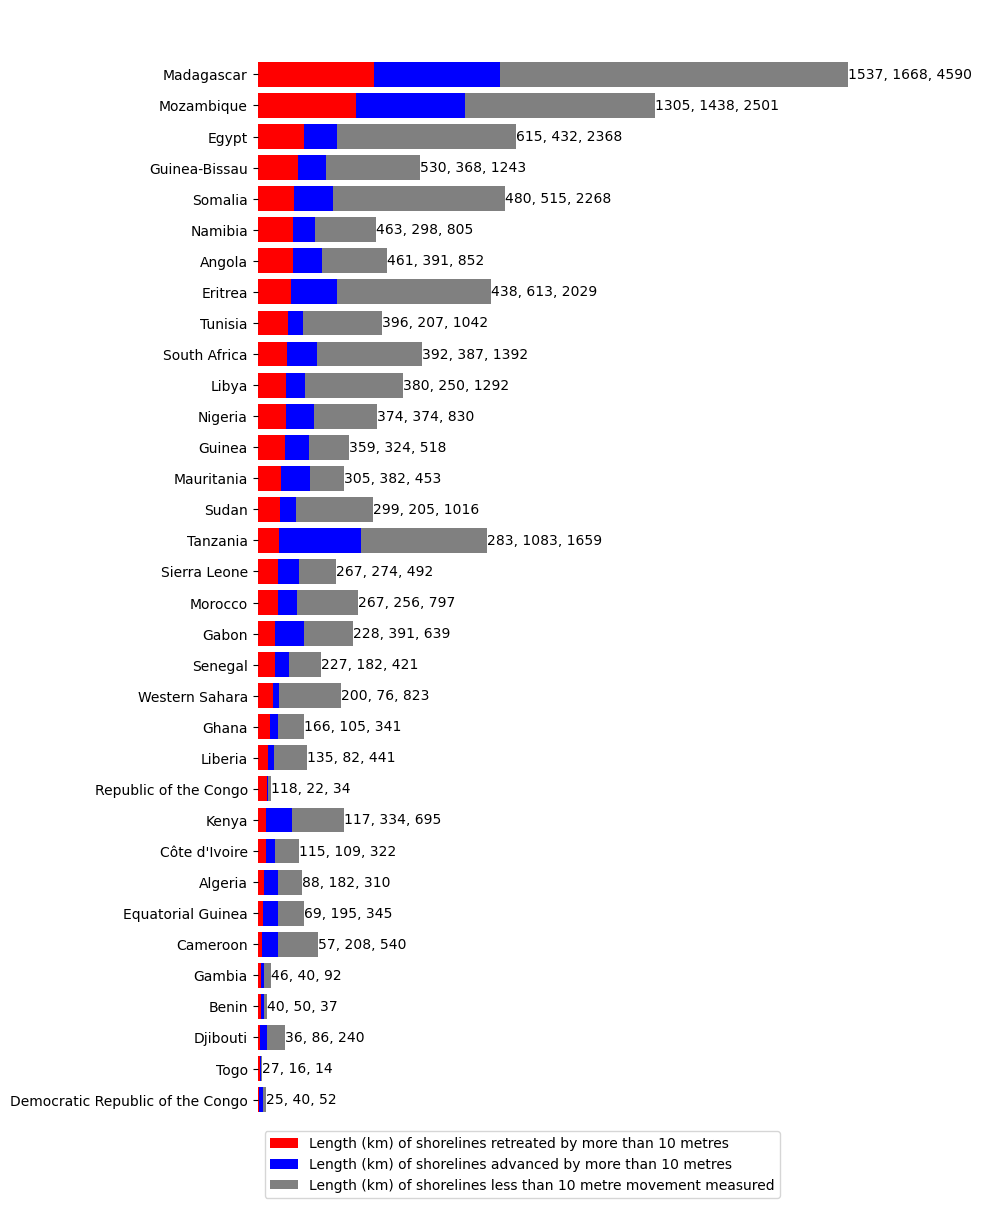

In [37]:
countries_sorted = countries_summary.sort_values(by='km_negsm10')

countries = list(countries_sorted.Country)
red_data = list(countries_sorted.km_negsm10)
white_data = list(countries_sorted.km_possm10)
blue_data = list(countries_sorted.km_nosm)

# Set the color scheme for the segments
colors = ['red', 'blue', 'grey']

# Create a list of indices for the bars
indices = np.arange(len(countries))

fig, ax = plt.subplots(figsize=(8,15))

# Plot the stacked horizontal bars
red_bars = ax.barh(indices, red_data, color=colors[0], label='Length (km) of shorelines retreated by more than 10 metres')
white_bars = ax.barh(indices, white_data, left=red_data, color=colors[1], label='Length (km) of shorelines advanced by more than 10 metres')
blue_bars = ax.barh(indices, blue_data, left=np.add(red_data, white_data), color=colors[2], label='Length (km) of shorelines less than 10 metre movement measured')

# Remove spines and ticks
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

# Add data value text to the center of each bar segment
for i in range(len(countries)):
    total_width = red_data[i] + white_data[i] + blue_data[i]
    x_center = total_width
    y_center = indices[i]
    ax.text(x_center, y_center, f"{round(red_data[i])}, {round(white_data[i])}, {round(blue_data[i])}", ha='left', va='center')

# Set the y-axis ticks and labels
ax.set_yticks(indices)
ax.set_yticklabels(countries)

# Place the legend outside of the figure
ax.legend(loc='center left', bbox_to_anchor=(0, 0), ncol=1)

fig.savefig('../figure/countries_sm_km.png',bbox_inches='tight')

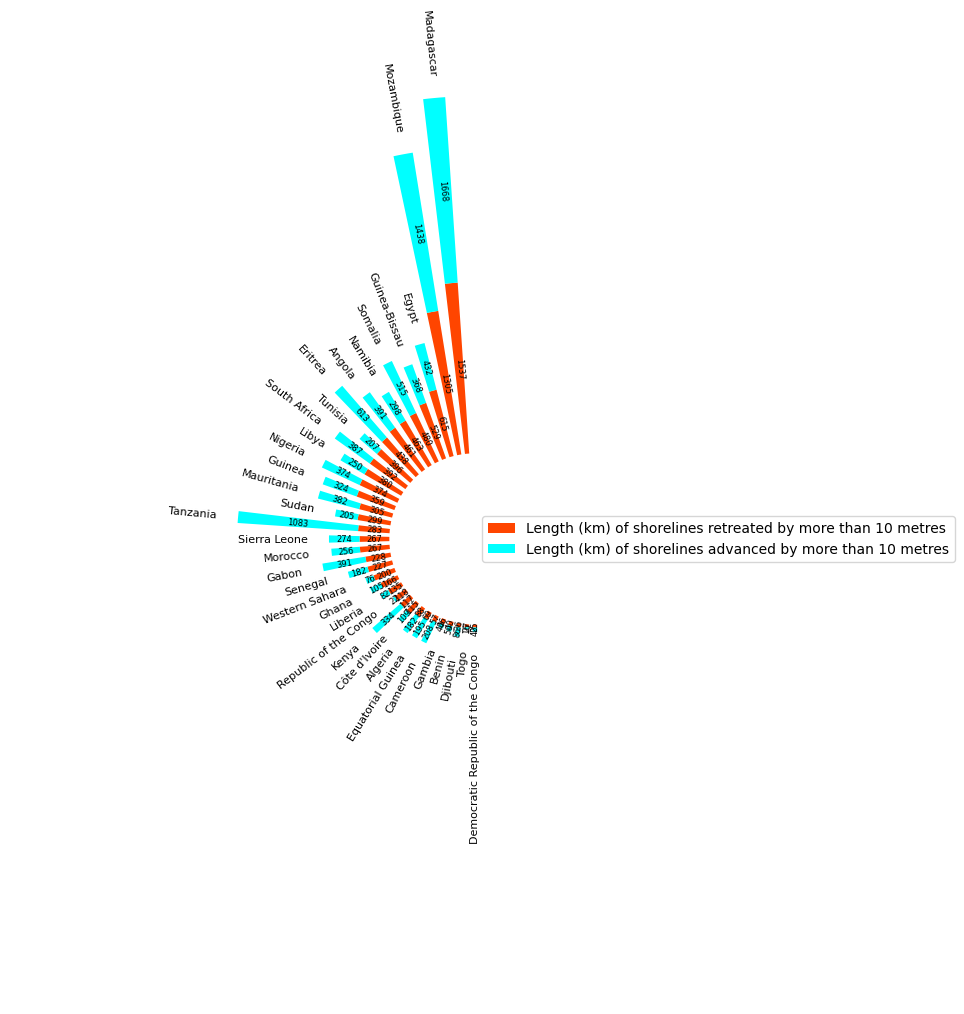

In [38]:
countries_sorted = countries_summary.sort_values(by='km_negsm10')

countries = list(countries_sorted.Country)
neg_data = list(countries_sorted.km_negsm10)
pos_data = list(countries_sorted.km_possm10)
non_data = list(countries_sorted.km_nosm)

# Set the color scheme for the segments
colors = ['orangered', 'cyan', 'grey']

# Calculate the angle for each bar
angles = np.linspace(0, np.pi, len(countries), endpoint=False)

# Create a polar plot
fig = plt.figure(figsize=(12, 16))
ax = fig.add_subplot(111, polar=True)

base=[np.max(neg_data)/2]*len(neg_data)
w=0.05
# Plot the red segments
ax.bar(angles, base, width=w, color='white')
neg_bars=ax.bar(angles, neg_data, width=w, bottom=base, color=colors[0], label='Length (km) of shorelines retreated by more than 10 metres')
# Plot the white segments on top of the red segments
pos_bars=ax.bar(angles, pos_data, width=w, bottom=np.add(base, neg_data), color=colors[1], label='Length (km) of shorelines advanced by more than 10 metres')
# Plot the blue segments on top of the red and white segments
#ax.bar(angles, blue_data, width=0.5, bottom=np.add(red_data, white_data), color=colors[2], label='Blue')

# Set the starting angle at the top (North)
ax.set_theta_zero_location("S")

# Set the clockwise direction for the bars
ax.set_theta_direction(-1)

# Set the tick labels
ax.set_xticks([])
ax.set_yticks([])
ax.axis("off")

# Place the legend outside of the figure
ax.legend(loc='center left', bbox_to_anchor=(0.5, 0.5), ncol=1)

# Add country labels radially
for angle, country, label_radius in zip(angles, countries, np.add(np.add(np.add(neg_data, pos_data), base), np.max(neg_data)/8)):
    ax.text(angle, label_radius, country, ha='right', va='center', fontsize=8,
            rotation=270,#np.degrees(angle), 
            rotation_mode='anchor', transform_rotates_text=True)

# Add data value text to the center of each colored bar segment
for bars in [neg_bars, pos_bars]:
    for bar in bars:
        h = bar.get_height()
        x_center = bar.get_x() + bar.get_width() / 2
        y_center = bar.get_y() + bar.get_height() / 2
        ax.text(x_center, y_center, str(round(h)), ha='center', va='center', fontsize=6, 
                color='black', rotation=270, rotation_mode='anchor', transform_rotates_text=True)

# Remove gridlines
ax.grid(True)

fig.savefig('../figure/countries_sm_km_polar.png',bbox_inches='tight')

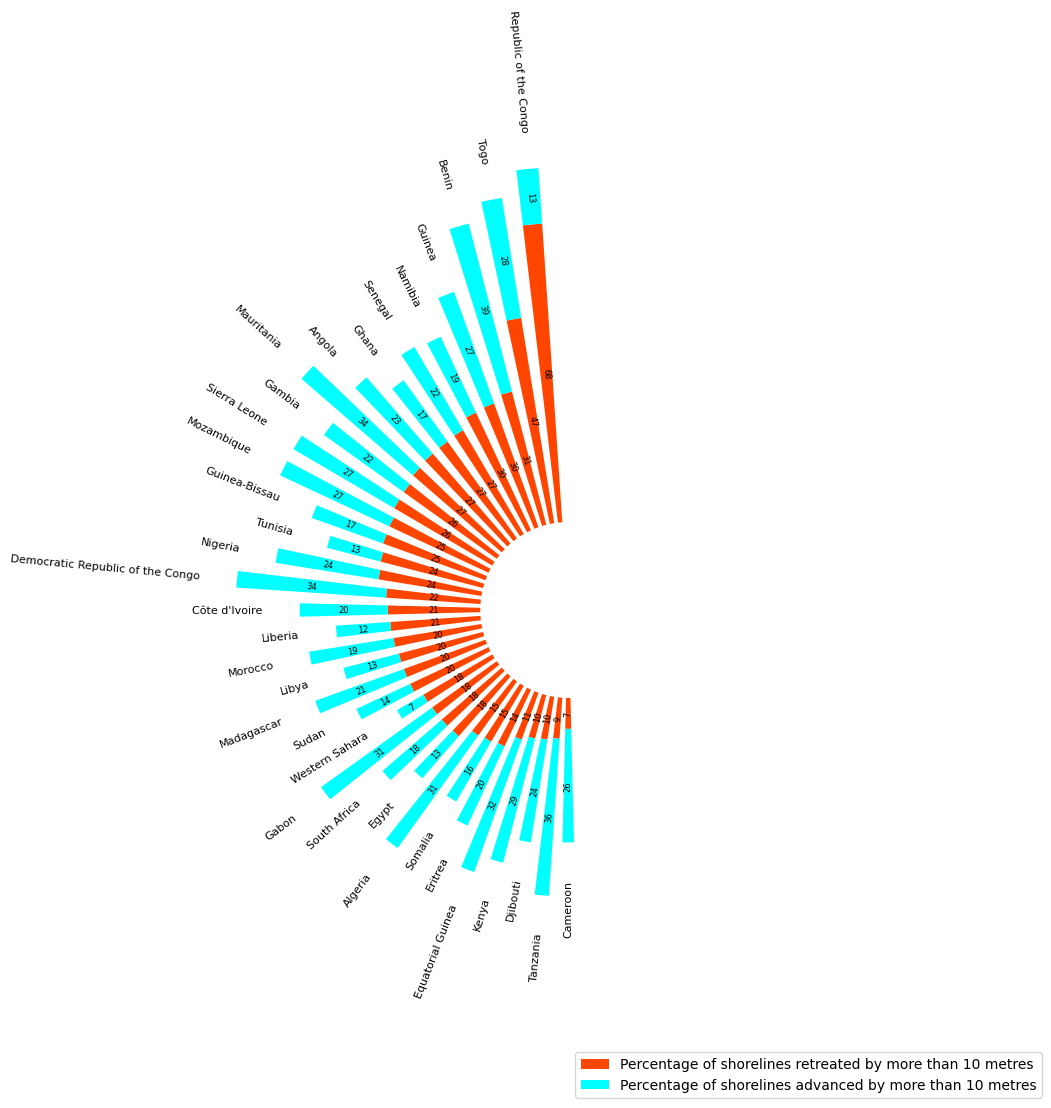

In [39]:
countries_sorted = countries_summary.sort_values(by='perc_negsm10')


countries = list(countries_sorted.Country)
neg_data = list(countries_sorted.perc_negsm10)
pos_data = list(countries_sorted.perc_possm10)

# Set the color scheme for the segments
colors = ['orangered', 'cyan', 'grey']

# Calculate the angle for each bar
angles = np.linspace(0, np.pi, len(countries), endpoint=False)

# Create a polar plot
fig = plt.figure(figsize=(12, 16))
ax = fig.add_subplot(111, polar=True)

base= 20 #[np.max(neg_data)/2]*len(neg_data)
w=0.05
# Plot the red segments
ax.bar(angles, base, width=w, color='white')
neg_bars = ax.bar(angles, neg_data, width=w, bottom=base, color=colors[0], label='Percentage of shorelines retreated by more than 10 metres')
# Plot the white segments on top of the red segments
pos_bars = ax.bar(angles, pos_data, width=w, bottom=np.add(base, neg_data), color=colors[1], label='Percentage of shorelines advanced by more than 10 metres')
# Plot the blue segments on top of the red and white segments
#ax.bar(angles, blue_data, width=0.5, bottom=np.add(red_data, white_data), color=colors[2], label='Blue')

# Set the starting angle at the top (North)
ax.set_theta_zero_location("S")

# Set the clockwise direction for the bars
ax.set_theta_direction(-1)

# Set the tick labels
ax.set_xticks([])
ax.set_yticks([])
ax.axis("off")

# Place the legend outside of the figure
ax.legend(loc='center left', bbox_to_anchor=(0.5, 0.), ncol=1)

# Add country labels radially
for angle, country, label_radius in zip(angles, countries, np.add(np.add(np.add(neg_data, pos_data), base), np.max(neg_data)/8)):
    ax.text(angle, label_radius, country, ha='right', va='center', fontsize=8,
            rotation=270,#np.degrees(angle), 
            rotation_mode='anchor', transform_rotates_text=True)

# Add data value text to the center of each colored bar segment
for bars in [neg_bars, pos_bars]:
    for bar in bars:
        h = bar.get_height()
        x_center = bar.get_x() + bar.get_width() / 2
        y_center = bar.get_y() + bar.get_height() / 2
        ax.text(x_center, y_center, str(round(h)), ha='center', va='center', fontsize=6, 
                color='black', rotation=270, rotation_mode='anchor', transform_rotates_text=True)

        
fig.savefig('../figure/countries_sm_perc_polar_360.png',bbox_inches='tight')

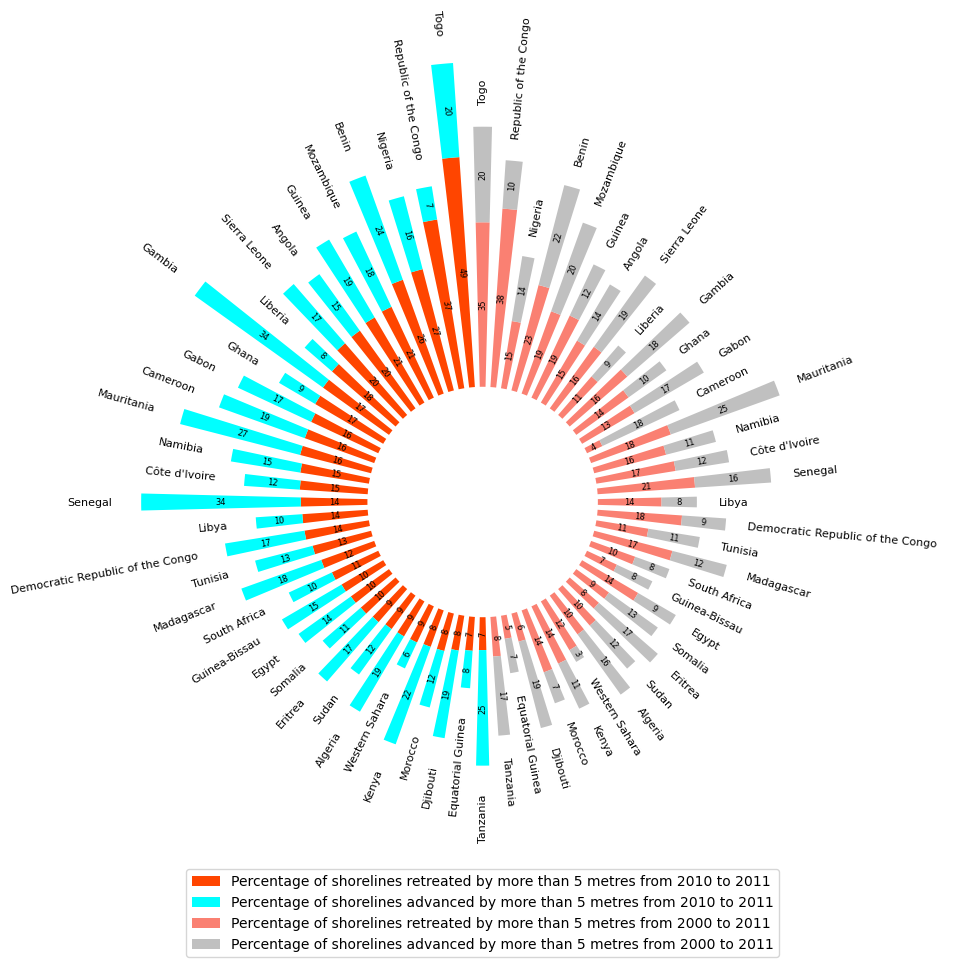

In [40]:
countries_sorted = countries_summary.sort_values(by='perc_negsm5_2010_2021')

countries = list(countries_sorted.Country)
neg_data = list(countries_sorted.perc_negsm5_2010_2021)
pos_data = list(countries_sorted.perc_possm5_2010_2021)

# Set the color scheme for the segments
colors = ['orangered', 'aqua', 'grey']

# Calculate the angle for each bar
angles = np.linspace(0, np.pi, len(countries), endpoint=False)

# Create a polar plot
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, polar=True)

base=[np.max(neg_data)/2]*len(neg_data)
w=0.05
# Plot the red segments
ax.bar(angles, base, width=w, color='white')
neg_bars = ax.bar(angles, neg_data, width=w, bottom=base, color=colors[0], label='Percentage of shorelines retreated by more than 5 metres from 2010 to 2011')
# Plot the white segments on top of the red segments
pos_bars = ax.bar(angles, pos_data, width=w, bottom=np.add(base, neg_data), color=colors[1], label='Percentage of shorelines advanced by more than 5 metres from 2010 to 2011')
# Plot the blue segments on top of the red and white segments
#ax.bar(angles, blue_data, width=0.5, bottom=np.add(red_data, white_data), color=colors[2], label='Blue')

# Set the starting angle at the top (North)
ax.set_theta_zero_location("S")

# Set the clockwise direction for the bars
ax.set_theta_direction(-1)

# Set the tick labels
ax.set_xticks([])
ax.set_yticks([])
ax.axis("off")

# Place the legend outside of the figure
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 0), ncol=1)

# Add country labels radially
for angle, country, label_radius in zip(angles, countries, np.add(np.add(np.add(neg_data, pos_data), base), np.max(neg_data)/8)):
    ax.text(angle, label_radius, country, ha='right', va='center', fontsize=8,
            rotation=270,#np.degrees(angle), 
            rotation_mode='anchor', transform_rotates_text=True)

    
# Add data value text to the center of each colored bar segment
for bars in [neg_bars, pos_bars]:
    for bar in bars:
        h = bar.get_height()
        x_center = bar.get_x() + bar.get_width() / 2
        y_center = bar.get_y() + bar.get_height() / 2
        ax.text(x_center, y_center, str(round(h)), ha='center', va='center', fontsize=6, 
                color='black', rotation=270, rotation_mode='anchor', transform_rotates_text=True)


countries = list(countries_sorted.Country)[::-1]
neg_data = list(countries_sorted.perc_negsm5_2000_2011)[::-1]
pos_data = list(countries_sorted.perc_possm5_2000_2011)[::-1]

# Set the color scheme for the segments
colors = ['salmon', 'silver', 'grey']

# Calculate the angle for each bar
angles = np.linspace(np.pi, 2*np.pi, len(countries), endpoint=False)

w=0.05
# Plot the red segments
ax.bar(angles, base, width=w, color='white')
neg_bars = ax.bar(angles, neg_data, width=w, bottom=base, color=colors[0], label='Percentage of shorelines retreated by more than 5 metres from 2000 to 2011')
# Plot the white segments on top of the red segments
pos_bars = ax.bar(angles, pos_data, width=w, bottom=np.add(base, neg_data), color=colors[1], label='Percentage of shorelines advanced by more than 5 metres from 2000 to 2011')
# Plot the blue segments on top of the red and white segments
#ax.bar(angles, blue_data, width=0.5, bottom=np.add(red_data, white_data), color=colors[2], label='Blue')


# Set the tick labels
ax.set_xticks([])
ax.set_yticks([])
ax.axis("off")

# Place the legend outside of the figure
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 0), ncol=1)

# Add country labels radially
for angle, country, label_radius in zip(angles, countries, np.add(np.add(np.add(neg_data, pos_data), base), np.max(neg_data)/8)):
    ax.text(angle, label_radius, country, ha='left', va='center', fontsize=8,
            rotation=90,#np.degrees(angle), 
            rotation_mode='anchor', transform_rotates_text=True)

    
# Add data value text to the center of each colored bar segment
for bars in [neg_bars, pos_bars]:
    for bar in bars:
        h = bar.get_height()
        x_center = bar.get_x() + bar.get_width() / 2
        y_center = bar.get_y() + bar.get_height() / 2
        ax.text(x_center, y_center, str(round(h)), ha='center', va='center', fontsize=6, 
                color='black', rotation=90, rotation_mode='anchor', transform_rotates_text=True)

fig.savefig('../figure/countries_sm_perc_polar_2_periods_significant.png',bbox_inches='tight')